In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path

Loaded 0IEZB.jpg: size (1867, 1400)
Loaded 1SPV2.jpg: size (800, 1200)
Loaded 32RSR.jpg: size (768, 1024)
Loaded 0W21G.jpeg: size (2848, 4272)


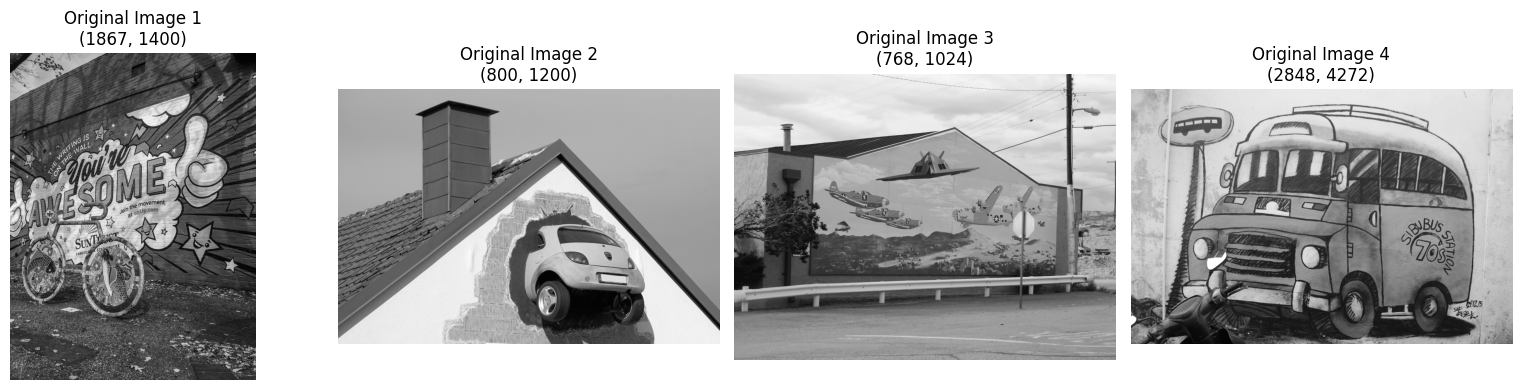

In [2]:
# Get all image files
image_folder = Path("sample_images")
image_files = list(image_folder.glob("*.jpg")) + list(image_folder.glob("*.jpeg"))

# Load and normalize all 4 images
images = []
original_sizes = []

for img_file in image_files[:4]:  # Take first 4 images
    # Load image in grayscale
    img = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
    # Normalize to [0, 1]
    img_normalized = img.astype(np.float64) / 255.0
    images.append(img_normalized)
    original_sizes.append(img_normalized.shape)
    print(f"Loaded {img_file.name}: size {img_normalized.shape}")

# Display original images
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axes[i].imshow(images[i], cmap='gray', vmin=0, vmax=1)
    axes[i].set_title(f'Original Image {i+1}\n{original_sizes[i]}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [3]:
# Create a Gaussian kernel for blurring
sigma = 2.0
k = int(2 * np.pi * sigma)
if k % 2 == 0:  # Make sure k is odd
    k += 1

print(f"Gaussian kernel size: {k}x{k}")
print(f"Sigma: {sigma}")

# Create Gaussian kernel using cv2
gaussian_kernel = cv2.getGaussianKernel(k, sigma)
gaussian_kernel = gaussian_kernel @ gaussian_kernel.T  # 2D kernel from 1D

print(f"Kernel sum: {np.sum(gaussian_kernel):.10f}")
print(f"Kernel shape: {gaussian_kernel.shape}")

Gaussian kernel size: 13x13
Sigma: 2.0
Kernel sum: 1.0000000000
Kernel shape: (13, 13)


In [4]:
# Method 1: Spatial domain convolution

spatial_blurred = []

for img_idx in range(4):
    f = images[img_idx]
    M, N = f.shape
    k_size = gaussian_kernel.shape[0]
    
    print(f"Convolving image {img_idx+1} (spatial)")
    
    # Pad the image
    pad = k_size // 2
    f_padded = cv2.copyMakeBorder(f, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    
    # Apply filter (cv2.filter2D does correlation, so we flip kernel for convolution)
    g_padded = cv2.filter2D(f_padded, -1, np.flip(np.flip(gaussian_kernel, 0), 1), borderType=cv2.BORDER_ISOLATED)
    
    # Extract center (original size)
    g = g_padded[pad:pad+M, pad:pad+N]
    
    spatial_blurred.append(g)
    print(f"  Complete")

Convolving image 1 (spatial)
  Complete
Convolving image 2 (spatial)
  Complete
Convolving image 3 (spatial)
  Complete
Convolving image 4 (spatial)
  Complete


In [5]:
# Method 2: Frequency domain filtering
frequency_blurred = []

for img_idx in range(4):
    f = images[img_idx]
    M, N = f.shape
    k_size = gaussian_kernel.shape[0]
    
    print(f"\nProcessing image {img_idx+1} (frequency)")
    
    # Pad image to match spatial domain
    pad = k_size // 2
    f_padded = cv2.copyMakeBorder(f, pad, pad, pad, pad, cv2.BORDER_REFLECT)
    M_pad, N_pad = f_padded.shape
    
    # Get optimal DFT size
    optimal_M = cv2.getOptimalDFTSize(M_pad)
    optimal_N = cv2.getOptimalDFTSize(N_pad)
    
    # Pad to optimal size with zeros
    f_dft = np.zeros((optimal_M, optimal_N), dtype=np.float64)
    f_dft[:M_pad, :N_pad] = f_padded
    
    # Pad kernel to same size
    h_dft = np.zeros((optimal_M, optimal_N), dtype=np.float64)
    h_dft[:k_size, :k_size] = gaussian_kernel
    # Shift kernel center to (0,0) for DFT
    h_dft = np.roll(h_dft, -(k_size//2), axis=0)
    h_dft = np.roll(h_dft, -(k_size//2), axis=1)
    
    # Compute DFT
    F = cv2.dft(f_dft, flags=cv2.DFT_COMPLEX_OUTPUT)
    H = cv2.dft(h_dft, flags=cv2.DFT_COMPLEX_OUTPUT)
    
    # Multiply in frequency domain
    G = cv2.mulSpectrums(F, H, flags=0)
    
    # Inverse DFT
    g_full = cv2.idft(G, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
    
    # Extract padded size first
    g_padded = g_full[:M_pad, :N_pad]
    
    # Then extract original size
    g = g_padded[pad:pad+M, pad:pad+N]
    
    frequency_blurred.append(g)
    print(f"  Complete (DFT size: {optimal_M}x{optimal_N})")


Processing image 1 (frequency)
  Complete (DFT size: 1920x1440)

Processing image 2 (frequency)
  Complete (DFT size: 864x1215)

Processing image 3 (frequency)
  Complete (DFT size: 800x1080)

Processing image 4 (frequency)
  Complete (DFT size: 2880x4320)


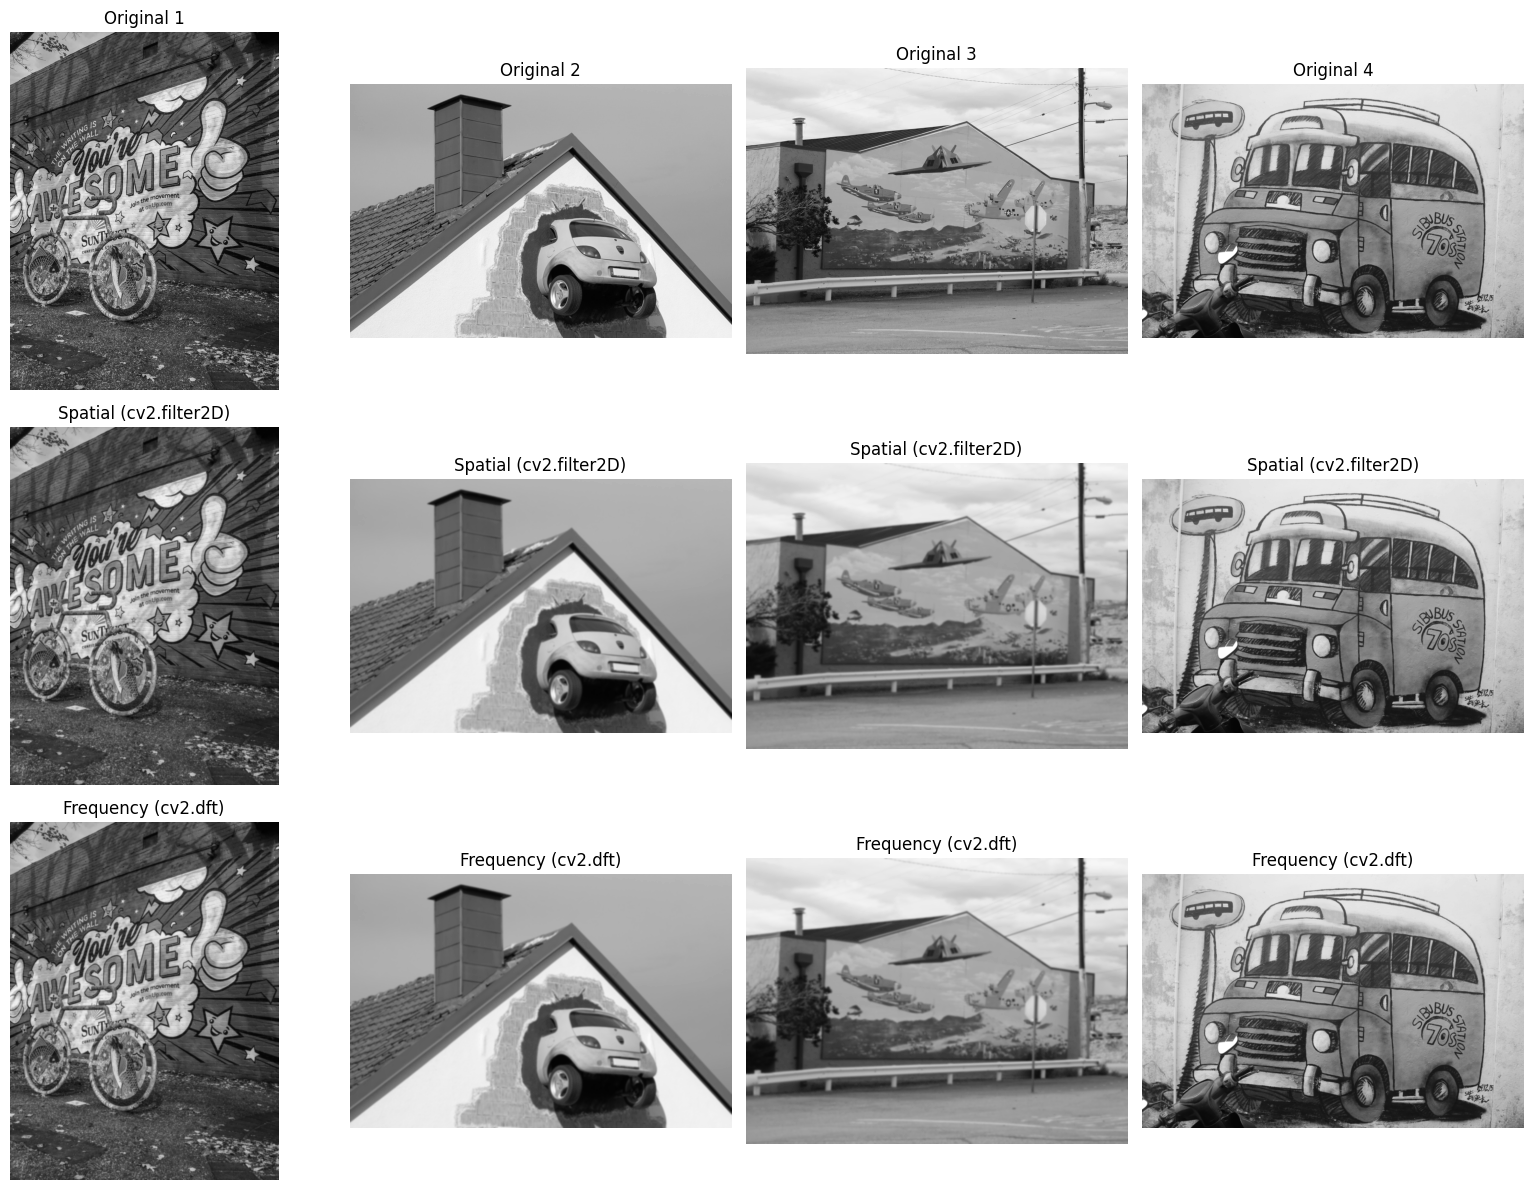

In [6]:
# Compare spatial and frequency domain results
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(4):
    # Original
    axes[0, i].imshow(images[i], cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')
    
    # Spatial domain
    axes[1, i].imshow(spatial_blurred[i], cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Spatial (cv2.filter2D)')
    axes[1, i].axis('off')
    
    # Frequency domain
    axes[2, i].imshow(frequency_blurred[i], cmap='gray', vmin=0, vmax=1)
    axes[2, i].set_title(f'Frequency (cv2.dft)')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Final Comparison
print("Comparison")

for i in range(4):
    spatial_result = spatial_blurred[i]
    frequency_result = frequency_blurred[i]
    
    # Calculate difference
    difference = np.abs(spatial_result - frequency_result)
    
    # Statistics
    max_diff = np.max(difference)
    mean_diff = np.mean(difference)
    relative_error = mean_diff / np.mean(spatial_result) * 100
    
    print(f"\nImage {i+1} ({original_sizes[i][0]}x{original_sizes[i][1]}):")
    print(f"  Maximum difference: {max_diff:.2e}")
    print(f"  Mean difference:    {mean_diff:.2e}")

# Visualize differences
# fig, axes = plt.subplots(1, 4, figsize=(16, 4))
# for i in range(4):
#     difference = np.abs(spatial_blurred[i] - frequency_blurred[i])
#     im = axes[i].imshow(difference, cmap='hot', vmin=0, vmax=np.max(difference))
#     axes[i].set_title(f'|Spatial - Frequency| {i+1}\nMax: {np.max(difference):.2e}')
#     axes[i].axis('off')
#     plt.colorbar(im, ax=axes[i], fraction=0.046)

# plt.tight_layout()
# plt.show()

Comparison

Image 1 (1867x1400):
  Maximum difference: 9.99e-16
  Mean difference:    1.22e-16

Image 2 (800x1200):
  Maximum difference: 1.11e-15
  Mean difference:    1.85e-16

Image 3 (768x1024):
  Maximum difference: 9.99e-16
  Mean difference:    1.58e-16

Image 4 (2848x4272):
  Maximum difference: 1.22e-15
  Mean difference:    1.81e-16
